<a href="https://colab.research.google.com/github/oleksandr-g-rock/flower_classification/blob/main/flowers_5_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification flowers 


---

https://www.kaggle.com/alxmamaev/flowers-recognition

---

Need sorted this dataset https://www.kaggle.com/alxmamaev/flowers-recognition and upload to server

---

Using InceptionV3, transfer learning, fine tuning, data augmentation, data vizualization
---



Need download sort images from google drive

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HbzdK2Qg74nkSl8W_kc4v7dhOzKcunMi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HbzdK2Qg74nkSl8W_kc4v7dhOzKcunMi" -O flowers.zip && rm -rf /tmp/cookies.txt

Need unzip folder

In [ ]:
!jar xvf flowers.zip

Download modules

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

Set image size & batch size

In [ ]:
image_size = 224
batch_size = 32

# Create image generator

In [ ]:
# folders with train dir & val dir
train_dir = '/content/flowers/train/'
test_dir = '/content/flowers/val/'
# 
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)

 Проверяем генератор

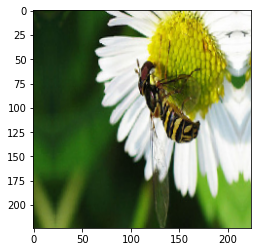

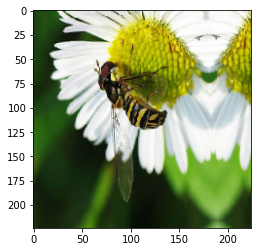

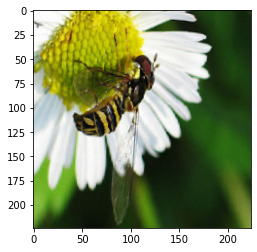

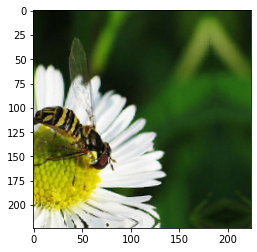

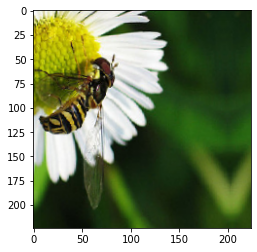

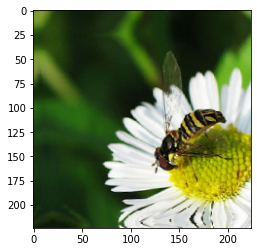

In [ ]:
img_path = '/content/flowers/train/daisy/daisy00001.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Setting train generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 2800 images belonging to 5 classes.


Setting test generator without data augmentation

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 700 images belonging to 5 classes.


Print count classes

In [ ]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Graph count images per classes "train"



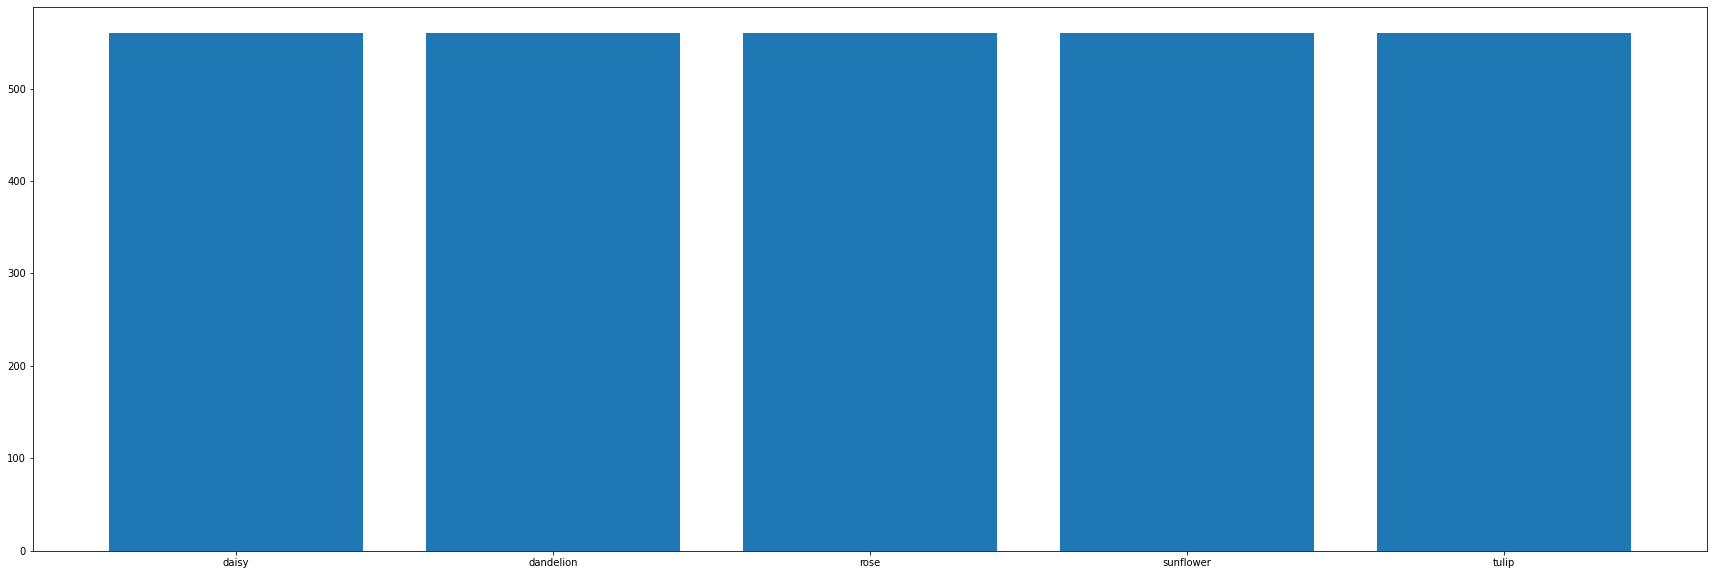

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

Graph count images per classes "test"

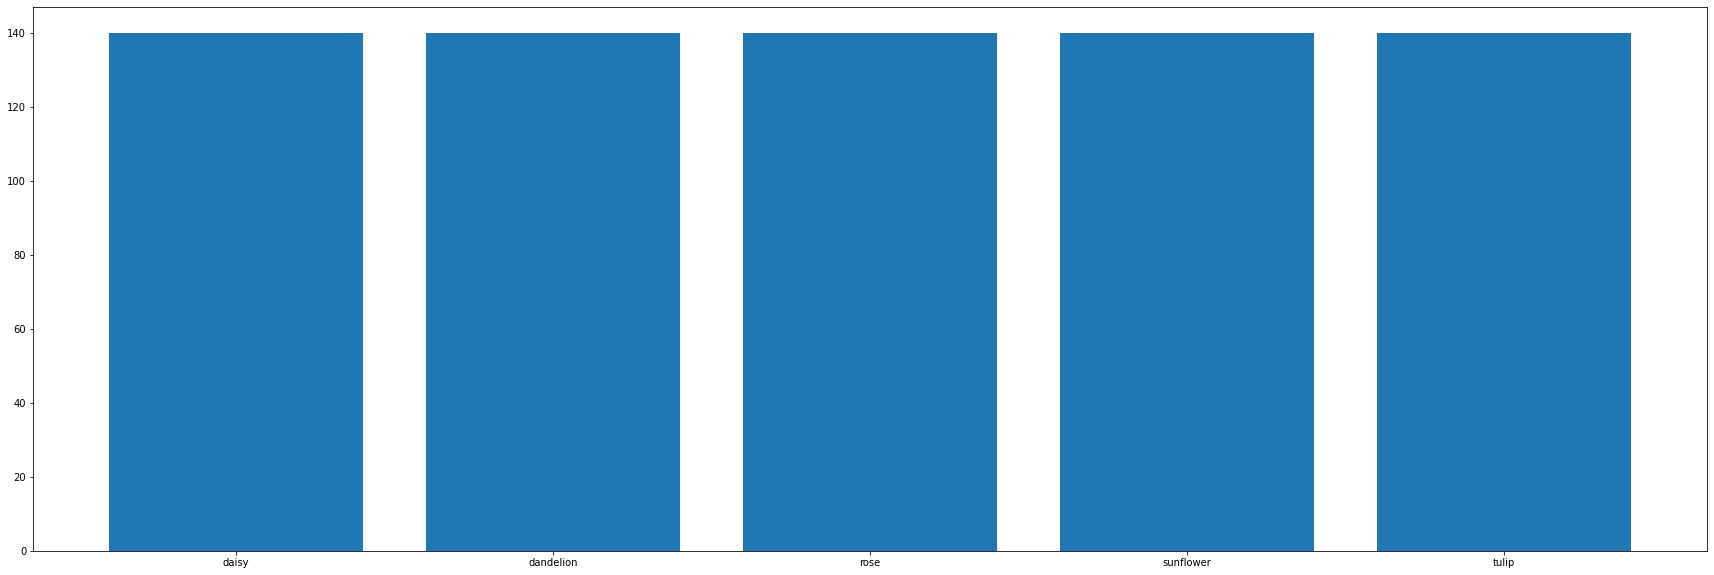

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 


# Download InceptionV3 model

In [ ]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.summary()

"Frozen" all weights pretrained models 

In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

# Created main layers for end inceptionV3 model

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [ ]:
model.summary()

# Train a composite neural network based on InceptionV3

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=40,
    verbose=2)

Epoch 1/40

Epoch 00001: val_loss improved from inf to 0.68182, saving model to inceptionv3_best.h5
40/40 - 16s - loss: 0.3633 - accuracy: 0.8671 - val_loss: 0.6818 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/40

Epoch 00002: val_loss improved from 0.68182 to 0.43163, saving model to inceptionv3_best.h5
40/40 - 15s - loss: 0.4060 - accuracy: 0.8523 - val_loss: 0.4316 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 3/40

Epoch 00003: val_loss did not improve from 0.43163
40/40 - 15s - loss: 0.3573 - accuracy: 0.8687 - val_loss: 0.8928 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/40

Epoch 00004: val_loss did not improve from 0.43163
40/40 - 15s - loss: 0.4001 - accuracy: 0.8586 - val_loss: 0.6648 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 5/40

Epoch 00005: val_loss did not improve from 0.43163
40/40 - 15s - loss: 0.3817 - accuracy: 0.8647 - val_loss: 0.8524 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 6/40

Epoch 00006: val_loss did not improve from 0.43163
40/40 - 15s - loss: 0.3597 - accuracy: 


Visualize the history of network learning

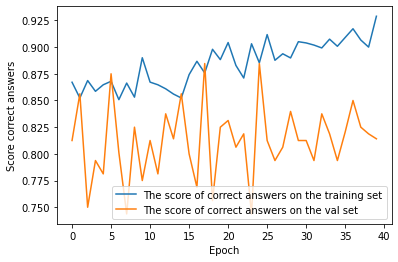

In [ ]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

# Fine tuning convolutional layers Inception V3

Download the best weights

In [ ]:
model.load_weights("inceptionv3_best.h5")

Defrost the last 2 blocks of Inception V3

In [ ]:
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True


Compile a network with defrosted layers. And start learning

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=50,
    verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 35.46066, saving model to inceptionv3_fine_tuned.h5
40/40 - 16s - loss: 1.0166 - accuracy: 0.7152 - val_loss: 35.4607 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 2/50

Epoch 00002: val_loss improved from 35.46066 to 2.65821, saving model to inceptionv3_fine_tuned.h5
40/40 - 16s - loss: 0.5950 - accuracy: 0.7930 - val_loss: 2.6582 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/50

Epoch 00003: val_loss improved from 2.65821 to 0.56129, saving model to inceptionv3_fine_tuned.h5
40/40 - 15s - loss: 0.5197 - accuracy: 0.8180 - val_loss: 0.5613 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.56129
40/40 - 15s - loss: 0.3750 - accuracy: 0.8742 - val_loss: 0.9643 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.56129
40/40 - 15s - loss: 0.4616 - accuracy: 0.8339 - val_loss: 1.0649 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 6/50

Epoch 00006: val_loss improv

Visualize the history of network learning

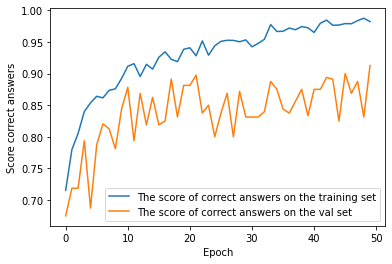

In [ ]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

Testing model and download the best weights

In [ ]:
# Load the model

model = tensorflow.keras.models.load_model('/content/inceptionv3_fine_tuned.h5')


Upload random photo from internet with flowers

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG/2880px-Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG

--2020-05-12 06:30:18--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG/2880px-Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1631195 (1.6M) [image/jpeg]
Saving to: ‘2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG’

2880px-Iglesia_de_N 100%[===================>]   1.55M  1.36MB/s    in 1.1s    

2020-05-12 06:30:21 (1.36 MB/s) - ‘2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG’ saved [1631195/1631195]



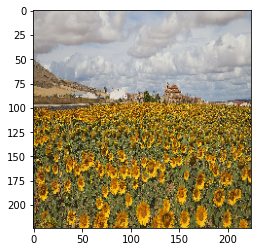

In [ ]:
img_path = '/content/2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG'

img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

array([[1.2830536e-04, 3.6059771e-06, 1.5354902e-07, 9.9982953e-01,
        3.8343369e-05]], dtype=float32)

List classes with numbers of classes:

'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[3]
